# 02 - Train Base Classifier

Goals:
1. Load data with configurable subset size
2. Create PyTorch DataLoaders with proper transforms
3. Train ResNet-50 for multi-label classification
4. Evaluate and validate F1 ≥ 0.40
5. Generate and save predictions for conformal methods

This notebook uses MPS acceleration for M3 Pro.

In [1]:
# Imports

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import json
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image

# Add src to path
PROJECT_ROOT = Path("..").resolve()
sys.path.insert(0, str(PROJECT_ROOT))

from config import CONFIG, LABELS, DATA_DIR, MODELS_DIR, RESULTS_DIR, print_config

# Print configuration
print_config()

EXPERIMENT CONFIGURATION

Data:
  subset_size: 25000
  image_size: 224
  batch_size: 32
  num_workers: 4

Training:
  phase1_epochs: 30
  phase2_epochs: 10
  phase1_lr: 0.001
  phase2_lr: 0.0001

Conformal:
  alpha: 0.1
  target_coverage: 0.9
  cwcs_lambda: 1.0

System:
  device: mps
  seed: 2024



In [2]:
# Set seeds for reproducibility

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # MPS doesn't have manual_seed but setting torch seed covers it

set_seed(CONFIG["seed"])
print(f"Random seed set to: {CONFIG['seed']}")

Random seed set to: 2024


In [3]:
# Setting up device

device = CONFIG["device"]

# Verify MPS is available
if device == "mps":
    if torch.backends.mps.is_available():
        print("MPS (Metal Performance Shaders) is available")
        device = torch.device("mps")
    else:
        print("MPS not available, falling back to CPU")
        device = torch.device("cpu")
elif device == "cuda":
    if torch.cuda.is_available():
        print(f"CUDA is available: {torch.cuda.get_device_name(0)}")
        device = torch.device("cuda")
    else:
        print("CUDA not available, falling back to CPU")
        device = torch.device("cpu")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")

MPS (Metal Performance Shaders) is available
Device: mps


In [4]:
# Load metadata

print("Loading metadata...")
metadata_path = DATA_DIR / "metadata_with_splits.csv"
df = pd.read_csv(metadata_path)
print(f"Total images in metadata: {len(df):,}")

# Load Kaggle path for images
kaggle_path_file = DATA_DIR / "kaggle_path.txt"
with open(kaggle_path_file, 'r') as f:
    KAGGLE_PATH = Path(f.read().strip())
print(f"Images location: {KAGGLE_PATH}")

Loading metadata...
Total images in metadata: 112,120
Images location: /Users/ADRIAN/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


In [5]:
# Apply subset if configured

subset_size = CONFIG["subset_size"]

if subset_size is not None and subset_size < len(df):
    print(f"\nApplying subset: {subset_size:,} images")

    # Sample proportionally from each split to maintain ratios
    df_subset = []
    for split in ['train', 'val', 'cal', 'test']:
        split_df = df[df['split'] == split]
        ratio = {'train': 0.70, 'val': 0.10, 'cal': 0.10, 'test': 0.10}[split]
        n_samples = int(subset_size * ratio)

        # Sample by patient to avoid data leakage
        patients = split_df['Patient ID'].unique()
        np.random.shuffle(patients)

        # Take patients until we have enough images
        selected_patients = []
        count = 0
        for p in patients:
            patient_images = len(split_df[split_df['Patient ID'] == p])
            if count + patient_images <= n_samples * 1.2:  # Allow 20% margin
                selected_patients.append(p)
                count += patient_images
            if count >= n_samples:
                break

        split_subset = split_df[split_df['Patient ID'].isin(selected_patients)]
        df_subset.append(split_subset)

    df = pd.concat(df_subset, ignore_index=True)
    print(f"Subset created: {len(df):,} images")

print(f"\nSplit distribution:")
print(df['split'].value_counts())


Applying subset: 25,000 images
Subset created: 25,022 images

Split distribution:
split
train    17500
cal       2512
val       2508
test      2502
Name: count, dtype: int64


In [6]:
# Filter to only images with at least one disease
print("\nFiltering to images with at least one disease label...")

def has_disease(finding_labels_str):
    """Check if image has at least one of our 14 diseases"""
    findings = finding_labels_str.split("|")
    for finding in findings:
        if finding in LABELS:
            return True
    return False

# Count before filtering
total_before = len(df)
no_finding_count = (~df['Finding Labels'].apply(has_disease)).sum()

# Filter
df = df[df['Finding Labels'].apply(has_disease)].reset_index(drop=True)

print(f"  Before filtering: {total_before:,} images")
print(f"  'No Finding' removed: {no_finding_count:,} images")
print(f"  After filtering: {len(df):,} images with diseases")

print(f"\nNew split distribution:")
print(df['split'].value_counts())

# Verify positive label rate improved
sample_labels = np.array([
    [1 if l in row.split("|") else 0 for l in LABELS]
    for row in df['Finding Labels'].head(1000)
])
new_positive_rate = sample_labels.mean() * 100
print(f"\nPositive label rate (sample): {new_positive_rate:.1f}%")


Filtering to images with at least one disease label...
  Before filtering: 25,022 images
  'No Finding' removed: 13,549 images
  After filtering: 11,473 images with diseases

New split distribution:
split
train    8067
test     1213
val      1141
cal      1052
Name: count, dtype: int64

Positive label rate (sample): 10.7%


In [7]:
# Define dataset class

class ChestXrayDataset(Dataset):
    """
    ChestX-ray14 Dataset for multi-label classification
    """

    def __init__(self, dataframe, image_root, labels, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_root = Path(image_root)
        self.labels = labels
        self.transform = transform

        # Find image directories (images are in subfolders)
        self.image_dirs = list(self.image_root.glob("images_*/images"))
        if not self.image_dirs:
            # Try direct path
            self.image_dirs = [self.image_root]

        print(f"Image directories found: {len(self.image_dirs)}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        image_name = row['Image Index']
        image_path = self._find_image(image_name)

        if image_path is None:
            raise FileNotFoundError(f"Image not found: {image_name}")

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Parse labels
        labels = self._parse_labels(row['Finding Labels'])
        labels = torch.from_numpy(labels)

        return image, labels

    def _find_image(self, image_name):
        """Search for image in all image directories"""
        for img_dir in self.image_dirs:
            img_path = img_dir / image_name
            if img_path.exists():
                return img_path
        return None

    def _parse_labels(self, finding_labels_str):
        """Convert label string to binary vector"""
        findings = finding_labels_str.split("|")
        binary = np.zeros(len(self.labels), dtype=np.float32)
        for finding in findings:
            if finding in self.labels:
                idx = self.labels.index(finding)
                binary[idx] = 1.0
        return binary

In [8]:
# Define transforms

image_size = CONFIG["image_size"]

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # ImageNet stats
])

eval_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

print(f"Image size: {image_size}x{image_size}")
print(f"Train augmentations: flip, rotation, affine")

Image size: 224x224
Train augmentations: flip, rotation, affine


In [9]:
# Create datasets and dataloaders

print("\nCreating datasets...")

train_df = df[df['split'] == 'train']
val_df = df[df['split'] == 'val']
cal_df = df[df['split'] == 'cal']
test_df = df[df['split'] == 'test']

train_dataset = ChestXrayDataset(train_df, KAGGLE_PATH, LABELS, transform=train_transform)
val_dataset = ChestXrayDataset(val_df, KAGGLE_PATH, LABELS, transform=eval_transform)
cal_dataset = ChestXrayDataset(cal_df, KAGGLE_PATH, LABELS, transform=eval_transform)
test_dataset = ChestXrayDataset(test_df, KAGGLE_PATH, LABELS, transform=eval_transform)

print(f"Train: {len(train_dataset):,} images")
print(f"Val:   {len(val_dataset):,} images")
print(f"Cal:   {len(cal_dataset):,} images")
print(f"Test:  {len(test_dataset):,} images")

# Create dataloaders
batch_size = CONFIG["batch_size"]
num_workers = 0
pin_memory = False

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=pin_memory)
cal_loader = DataLoader(cal_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=pin_memory)

print(f"\nBatch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")


Creating datasets...
Image directories found: 12
Image directories found: 12
Image directories found: 12
Image directories found: 12
Train: 8,067 images
Val:   1,141 images
Cal:   1,052 images
Test:  1,213 images

Batch size: 32
Train batches: 253


In [10]:
# Test data loading

print("\nTesting data loading...")
images, labels = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")
print(f"Label example: {labels[0].numpy()}")
print(f"Active labels: {[LABELS[i] for i in torch.where(labels[0] == 1)[0].tolist()]}")


Testing data loading...
Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32, 14])
Label example: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Active labels: ['Infiltration']


In [11]:
# Define model

class ChestXrayClassifier(nn.Module):
    """
    ResNet-50 based multi-label classifier
    """

    def __init__(self, num_classes=14, dropout=0.5, pretrained=True):
        super().__init__()

        # Load pretrained ResNet-50
        weights = models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        self.backbone = models.resnet50(weights=weights)

        # Get feature dimension
        num_features = self.backbone.fc.in_features

        # Replace final layer with custom head
        self.backbone.fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, num_classes),
            nn.Sigmoid()  # Multi-label: independent probabilities
        )

        # Track which layers are frozen
        self.backbone_frozen = False

    def freeze_backbone(self):
        """Freeze all backbone parameters"""
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.backbone_frozen = True
        print("Backbone frozen")

    def unfreeze_backbone(self, layers=['layer3', 'layer4']):
        """Unfreeze specific backbone layers"""
        for name, module in self.backbone.named_children():
            if name in layers:
                for param in module.parameters():
                    param.requires_grad = True
                print(f"Unfroze: {name}")
        self.backbone_frozen = False

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# Create model
model = ChestXrayClassifier(
    num_classes=len(LABELS),
    dropout=CONFIG["dropout"],
    pretrained=CONFIG["pretrained"]
)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel: ResNet-50")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model: ResNet-50
Total parameters: 23,536,718
Trainable parameters: 23,536,718


In [12]:
# Define loss function with class weights

def compute_class_weights(dataloader, num_classes):
    """Compute class weights for imbalanced dataset"""
    label_counts = torch.zeros(num_classes)
    total_samples = 0

    for _, labels in tqdm(dataloader, desc="Computing class weights"):
        label_counts += labels.sum(dim=0)
        total_samples += labels.size(0)

    # Weight = total / (2 * count), capped for rare classes
    weights = total_samples / (2 * (label_counts + 1))
    weights = torch.clamp(weights, min=0.5, max=10.0)  # Prevent extreme weights

    return weights

print("Computing class weights...")
class_weights = compute_class_weights(train_loader, len(LABELS))
class_weights = class_weights.to(device)

print("\nClass weights:")
for i, (label, weight) in enumerate(zip(LABELS, class_weights)):
    print(f"  {label}: {weight:.2f}")

Computing class weights...


Computing class weights: 100%|██████████| 253/253 [01:12<00:00,  3.50it/s]


Class weights:
  Atelectasis: 2.23
  Cardiomegaly: 9.06
  Effusion: 1.90
  Infiltration: 1.28
  Mass: 4.25
  Nodule: 4.44
  Pneumonia: 10.00
  Pneumothorax: 5.51
  Consolidation: 5.21
  Edema: 9.45
  Emphysema: 9.63
  Fibrosis: 10.00
  Pleural_Thickening: 7.35
  Hernia: 10.00


In [13]:
# Define weighted BCE loss

class WeightedBCELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights

    def forward(self, predictions, targets):
        # Binary cross-entropy with class weights
        bce = -(
            targets * torch.log(predictions + 1e-7) * self.weights +
            (1 - targets) * torch.log(1 - predictions + 1e-7)
        )
        return bce.mean()

criterion = WeightedBCELoss(class_weights)

In [14]:
# Define training functions

def train_epoch(model, loader, criterion, optimizer, device, grad_clip=1.0):
    model.train()
    total_loss = 0.0

    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()
        total_loss += loss.item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(loader)


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        all_preds.append(outputs.cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return total_loss / len(loader), all_preds, all_labels


def compute_metrics(predictions, labels, threshold=0.5):
    """Compute multi-label classification metrics"""
    preds_binary = (predictions > threshold).float()

    # Per-label metrics
    f1_scores = []
    precisions = []
    recalls = []

    for k in range(labels.shape[1]):
        tp = ((preds_binary[:, k] == 1) & (labels[:, k] == 1)).sum().item()
        fp = ((preds_binary[:, k] == 1) & (labels[:, k] == 0)).sum().item()
        fn = ((preds_binary[:, k] == 0) & (labels[:, k] == 1)).sum().item()

        precision = tp / (tp + fp + 1e-7)
        recall = tp / (tp + fn + 1e-7)
        f1 = 2 * precision * recall / (precision + recall + 1e-7)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    return {
        'macro_f1': np.mean(f1_scores),
        'macro_precision': np.mean(precisions),
        'macro_recall': np.mean(recalls),
        'per_label_f1': f1_scores
    }

In [15]:
# Training loop

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

# Phase 1: Train head only
print("\n--- Phase 1: Training classification head (backbone frozen) ---")
model.freeze_backbone()

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG["phase1_lr"],
    weight_decay=CONFIG["weight_decay"]
)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

best_f1 = 0.0
patience_counter = 0
history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

for epoch in range(CONFIG["phase1_epochs"]):
    print(f"\nEpoch {epoch+1}/{CONFIG['phase1_epochs']}")

    train_loss = train_epoch(model, train_loader, criterion, optimizer, device,
                             CONFIG["gradient_clip_norm"])
    val_loss, val_preds, val_labels = evaluate(model, val_loader, criterion, device)
    metrics = compute_metrics(val_preds, val_labels)

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(metrics['macro_f1'])

    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val F1:     {metrics['macro_f1']:.4f}")

    if metrics['macro_f1'] > best_f1:
        best_f1 = metrics['macro_f1']
        torch.save(model.state_dict(), MODELS_DIR / "best_model.pth")
        patience_counter = 0
        print(f"  ✓ New best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= CONFIG["early_stopping_patience"]:
            print(f"  Early stopping triggered!")
            break


STARTING TRAINING

--- Phase 1: Training classification head (backbone frozen) ---
Backbone frozen

Epoch 1/30


Evaluating: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


  Train Loss: 0.7989
  Val Loss:   0.7697
  Val F1:     0.1249
  ✓ New best model saved!

Epoch 2/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]


  Train Loss: 0.7728
  Val Loss:   0.7589
  Val F1:     0.1360
  ✓ New best model saved!

Epoch 3/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]


  Train Loss: 0.7619
  Val Loss:   0.7579
  Val F1:     0.1616
  ✓ New best model saved!

Epoch 4/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]


  Train Loss: 0.7567
  Val Loss:   0.7536
  Val F1:     0.1629
  ✓ New best model saved!

Epoch 5/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]


  Train Loss: 0.7522
  Val Loss:   0.7571
  Val F1:     0.1735
  ✓ New best model saved!

Epoch 6/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]


  Train Loss: 0.7575
  Val Loss:   0.7540
  Val F1:     0.1538

Epoch 7/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]


  Train Loss: 0.7501
  Val Loss:   0.7551
  Val F1:     0.1668

Epoch 8/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]


  Train Loss: 0.7470
  Val Loss:   0.7526
  Val F1:     0.1667

Epoch 9/30


Evaluating: 100%|██████████| 36/36 [00:14<00:00,  2.41it/s]


  Train Loss: 0.7453
  Val Loss:   0.7502
  Val F1:     0.1721

Epoch 10/30


Evaluating: 100%|██████████| 36/36 [00:14<00:00,  2.41it/s]


  Train Loss: 0.7446
  Val Loss:   0.7460
  Val F1:     0.1765
  ✓ New best model saved!

Epoch 11/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s]


  Train Loss: 0.7446
  Val Loss:   0.7498
  Val F1:     0.1700

Epoch 12/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]


  Train Loss: 0.7448
  Val Loss:   0.7487
  Val F1:     0.1732

Epoch 13/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]


  Train Loss: 0.7383
  Val Loss:   0.7443
  Val F1:     0.1796
  ✓ New best model saved!

Epoch 14/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]


  Train Loss: 0.7384
  Val Loss:   0.7427
  Val F1:     0.1914
  ✓ New best model saved!

Epoch 15/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]


  Train Loss: 0.7360
  Val Loss:   0.7439
  Val F1:     0.1969
  ✓ New best model saved!

Epoch 16/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.40it/s]


  Train Loss: 0.7418
  Val Loss:   0.7449
  Val F1:     0.1758

Epoch 17/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]


  Train Loss: 0.7378
  Val Loss:   0.7389
  Val F1:     0.1776

Epoch 18/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s]


  Train Loss: 0.7357
  Val Loss:   0.7364
  Val F1:     0.2087
  ✓ New best model saved!

Epoch 19/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]


  Train Loss: 0.7330
  Val Loss:   0.7425
  Val F1:     0.1834

Epoch 20/30


Evaluating: 100%|██████████| 36/36 [00:14<00:00,  2.42it/s]


  Train Loss: 0.7307
  Val Loss:   0.7415
  Val F1:     0.2031

Epoch 21/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]


  Train Loss: 0.7391
  Val Loss:   0.7405
  Val F1:     0.1947

Epoch 22/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s]


  Train Loss: 0.7360
  Val Loss:   0.7381
  Val F1:     0.1905

Epoch 23/30


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]

  Train Loss: 0.7325
  Val Loss:   0.7402
  Val F1:     0.1892
  Early stopping triggered!


In [16]:
# Fine-tune backbone

print("\n--- Phase 2: Fine-tuning backbone layers 3-4 ---")
model.load_state_dict(torch.load(MODELS_DIR / "best_model.pth"))
model.unfreeze_backbone(['layer3', 'layer4'])

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG["phase2_lr"],
    weight_decay=CONFIG["weight_decay"]
)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)

patience_counter = 0

for epoch in range(CONFIG["phase2_epochs"]):
    print(f"\nEpoch {CONFIG['phase1_epochs'] + epoch + 1}/{CONFIG['phase1_epochs'] + CONFIG['phase2_epochs']}")

    train_loss = train_epoch(model, train_loader, criterion, optimizer, device,
                             CONFIG["gradient_clip_norm"])
    val_loss, val_preds, val_labels = evaluate(model, val_loader, criterion, device)
    metrics = compute_metrics(val_preds, val_labels)

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(metrics['macro_f1'])

    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val F1:     {metrics['macro_f1']:.4f}")

    if metrics['macro_f1'] > best_f1:
        best_f1 = metrics['macro_f1']
        torch.save(model.state_dict(), MODELS_DIR / "best_model.pth")
        patience_counter = 0
        print(f"  ✓ New best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= CONFIG["early_stopping_patience"]:
            print(f"  Early stopping triggered!")
            break

print(f"\n✓ Training complete! Best F1: {best_f1:.4f}")


--- Phase 2: Fine-tuning backbone layers 3-4 ---
Unfroze: layer3
Unfroze: layer4

Epoch 31/40


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]


  Train Loss: 0.7163
  Val Loss:   0.7054
  Val F1:     0.2452
  ✓ New best model saved!

Epoch 32/40


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]


  Train Loss: 0.6729
  Val Loss:   0.6972
  Val F1:     0.2716
  ✓ New best model saved!

Epoch 33/40


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]


  Train Loss: 0.6397
  Val Loss:   0.6923
  Val F1:     0.2841
  ✓ New best model saved!

Epoch 34/40


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]


  Train Loss: 0.6091
  Val Loss:   0.7037
  Val F1:     0.2991
  ✓ New best model saved!

Epoch 35/40


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]


  Train Loss: 0.5834
  Val Loss:   0.6915
  Val F1:     0.3050
  ✓ New best model saved!

Epoch 36/40


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]


  Train Loss: 0.5574
  Val Loss:   0.7079
  Val F1:     0.3062
  ✓ New best model saved!

Epoch 37/40


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]


  Train Loss: 0.5344
  Val Loss:   0.7202
  Val F1:     0.3081
  ✓ New best model saved!

Epoch 38/40


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]


  Train Loss: 0.5121
  Val Loss:   0.7456
  Val F1:     0.3119
  ✓ New best model saved!

Epoch 39/40


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]


  Train Loss: 0.4990
  Val Loss:   0.7484
  Val F1:     0.3155
  ✓ New best model saved!

Epoch 40/40


Evaluating: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]

  Train Loss: 0.4905
  Val Loss:   0.7633
  Val F1:     0.3210
  ✓ New best model saved!

✓ Training complete! Best F1: 0.3210


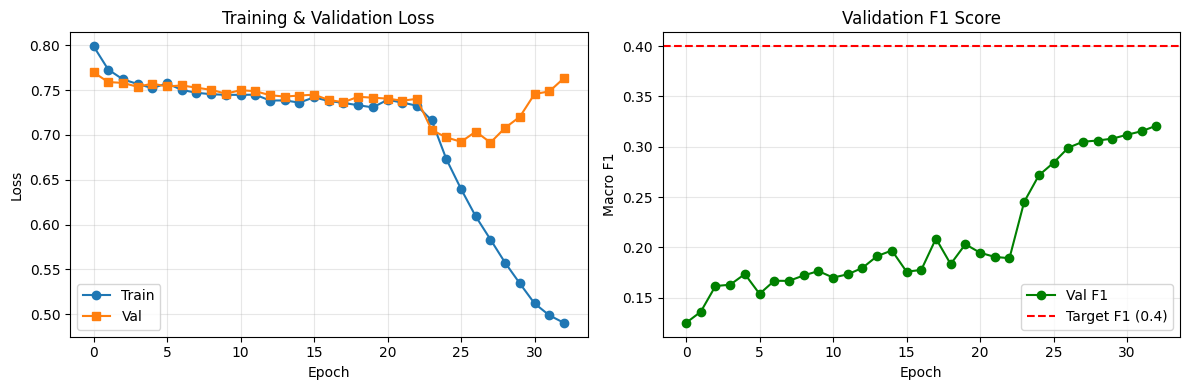

In [17]:
# Plot training history

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1 = axes[0]
ax1.plot(history['train_loss'], label='Train', marker='o')
ax1.plot(history['val_loss'], label='Val', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# F1 plot
ax2 = axes[1]
ax2.plot(history['val_f1'], label='Val F1', marker='o', color='green')
ax2.axhline(y=CONFIG["acceptable_f1"], color='red', linestyle='--',
            label=f'Target F1 ({CONFIG["acceptable_f1"]})')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Macro F1')
ax2.set_title('Validation F1 Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "figures" / "training_history.png", dpi=150)
plt.show()

In [18]:
# Final evaluation on test set

print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

# Load best model
model.load_state_dict(torch.load(MODELS_DIR / "best_model.pth"))
model.eval()

# Evaluate on test set
test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
test_metrics = compute_metrics(test_preds, test_labels)

print(f"\nTest Results:")
print(f"  Loss:      {test_loss:.4f}")
print(f"  Macro F1:  {test_metrics['macro_f1']:.4f}")
print(f"  Precision: {test_metrics['macro_precision']:.4f}")
print(f"  Recall:    {test_metrics['macro_recall']:.4f}")

print(f"\nPer-Label F1 Scores:")
for label, f1 in zip(LABELS, test_metrics['per_label_f1']):
    print(f"  {label:<20}: {f1:.4f}")

# Check if acceptable
if test_metrics['macro_f1'] >= CONFIG["acceptable_f1"]:
    print(f"\n✓ F1 score ({test_metrics['macro_f1']:.4f}) meets target ({CONFIG['acceptable_f1']})")
else:
    print(f"\n✗ F1 score ({test_metrics['macro_f1']:.4f}) below target ({CONFIG['acceptable_f1']})")
    print("  Consider: more epochs, larger subset, or hyperparameter tuning")


FINAL EVALUATION


Evaluating: 100%|██████████| 38/38 [00:16<00:00,  2.36it/s]


Test Results:
  Loss:      0.8098
  Macro F1:  0.3081
  Precision: 0.2781
  Recall:    0.3606

Per-Label F1 Scores:
  Atelectasis         : 0.4645
  Cardiomegaly        : 0.4110
  Effusion            : 0.4603
  Infiltration        : 0.5463
  Mass                : 0.3513
  Nodule              : 0.3092
  Pneumonia           : 0.0682
  Pneumothorax        : 0.3077
  Consolidation       : 0.2353
  Edema               : 0.1600
  Emphysema           : 0.5180
  Fibrosis            : 0.2698
  Pleural_Thickening  : 0.2115
  Hernia              : 0.0000

✗ F1 score (0.3081) below target (0.4)
  Consider: more epochs, larger subset, or hyperparameter tuning


In [19]:
# Generate predictions for conformal methods

print("\n" + "="*60)
print("GENERATING PREDICTIONS FOR CONFORMAL METHODS")
print("="*60)

@torch.no_grad()
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for images, labels in tqdm(loader, desc="Generating predictions"):
        images = images.to(device)
        outputs = model(images)
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.numpy())

    return np.vstack(all_preds), np.vstack(all_labels)

# Generate predictions for all splits
print("\nTrain set...")
train_preds, train_labels = get_predictions(model, train_loader, device)

print("Calibration set...")
cal_preds, cal_labels = get_predictions(model, cal_loader, device)

print("Test set...")
test_preds, test_labels_np = get_predictions(model, test_loader, device)

print(f"\nPrediction shapes:")
print(f"  Train: {train_preds.shape}")
print(f"  Cal:   {cal_preds.shape}")
print(f"  Test:  {test_preds.shape}")


GENERATING PREDICTIONS FOR CONFORMAL METHODS

Train set...


Generating predictions: 100%|██████████| 253/253 [01:49<00:00,  2.30it/s]


Calibration set...


Generating predictions: 100%|██████████| 33/33 [00:13<00:00,  2.37it/s]


Test set...


Generating predictions: 100%|██████████| 38/38 [00:16<00:00,  2.34it/s]


Prediction shapes:
  Train: (8067, 14)
  Cal:   (1052, 14)
  Test:  (1213, 14)


In [20]:
# Save predictions

print("\nSaving predictions...")

predictions_dir = RESULTS_DIR / "predictions"
predictions_dir.mkdir(exist_ok=True)

np.save(predictions_dir / "train_preds.npy", train_preds)
np.save(predictions_dir / "train_labels.npy", train_labels)
np.save(predictions_dir / "cal_preds.npy", cal_preds)
np.save(predictions_dir / "cal_labels.npy", cal_labels)
np.save(predictions_dir / "test_preds.npy", test_preds)
np.save(predictions_dir / "test_labels.npy", test_labels_np)

print(f"✓ Predictions saved to {predictions_dir}")

# Save metrics
metrics_path = RESULTS_DIR / "metrics" / "classifier_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump({
        'test_loss': float(test_loss),
        'macro_f1': float(test_metrics['macro_f1']),
        'macro_precision': float(test_metrics['macro_precision']),
        'macro_recall': float(test_metrics['macro_recall']),
        'per_label_f1': {label: float(f1) for label, f1 in zip(LABELS, test_metrics['per_label_f1'])},
        'config': {k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()},
        'timestamp': datetime.now().isoformat()
    }, f, indent=2)
print(f"✓ Metrics saved to {metrics_path}")


Saving predictions...
✓ Predictions saved to /Users/ADRIAN/Dev/College/Research Project/results/predictions
✓ Metrics saved to /Users/ADRIAN/Dev/College/Research Project/results/metrics/classifier_metrics.json


In [21]:
# Summary

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"""
Model: ResNet-50 (pretrained on ImageNet)
Dataset: ChestX-ray14 subset ({CONFIG['subset_size']} images)

Final Test Metrics:
  Macro F1:  {test_metrics['macro_f1']:.4f}
  Precision: {test_metrics['macro_precision']:.4f}
  Recall:    {test_metrics['macro_recall']:.4f}

Files saved:
  - {MODELS_DIR / 'best_model.pth'}
  - {predictions_dir / 'train_preds.npy'}
  - {predictions_dir / 'cal_preds.npy'}
  - {predictions_dir / 'test_preds.npy'}
  - {metrics_path}

Next step: Run notebook 03_standard_conformal.ipynb
""")


TRAINING COMPLETE

Model: ResNet-50 (pretrained on ImageNet)
Dataset: ChestX-ray14 subset (25000 images)

Final Test Metrics:
  Macro F1:  0.3081
  Precision: 0.2781
  Recall:    0.3606

Files saved:
  - /Users/ADRIAN/Dev/College/Research Project/models/checkpoints/best_model.pth
  - /Users/ADRIAN/Dev/College/Research Project/results/predictions/train_preds.npy
  - /Users/ADRIAN/Dev/College/Research Project/results/predictions/cal_preds.npy
  - /Users/ADRIAN/Dev/College/Research Project/results/predictions/test_preds.npy
  - /Users/ADRIAN/Dev/College/Research Project/results/metrics/classifier_metrics.json

Next step: Run notebook 03_standard_conformal.ipynb

